Summarize results of beads measurements 20230725 to .tsv.

In [1]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk')
from tqdm.notebook import tqdm
import dclab
import dctrack
from scripts.stress_hyper import (normal_stress_hyper_wc60_lc500_net_strain_ir_20240226,
                                  shear_stress_hyper_wc60_lc500_net_strain_ir_20240226,
                                  total_stress_hyper_wc60_lc500_net_strain_ir_20240226
                                  )
from scripts.extensional_paras import (fit_velocity,
                                       extension_rate_from_velocity_poly,
                                       recalculate_time)

C:\Users\freiche\ownCloud\PhD\Code_general\rtdc_tracking2.0\dctrack\track.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def compute_extensional_paras(tr_ds,
                              hyper_start=None, hyper_end=None,
                              stable_region_start=None,
                              filter=False, **filter_kws):
    """
    :param tr_ds: tracked_dataset instance of dctrack
    :return: df: dataframe with additional analysis parameters
    """
    if filter:
        tr_ds.filter_obj_distance = True
        tr_ds.filter_obj_n_events = True
        tr_ds.filter_backward_movement = True
        tr_ds.filter(inplace=True, return_filtered_ds=False, **filter_kws)

    df = tr_ds.get_extensional_paras_dataframe(hyper_start=hyper_start,
                                               hyper_end=hyper_end,
                                               stable_extension_start=stable_region_start
                                               )
    return df

In [3]:
data_exports = r"..\data_exports"
track_folder = r"..\..\tracked_data\20230725_Felix_paa_beads_hyper_channel_viscoelasticity"
rtdc_folder = r"..\..\raw_data\20230725_Felix_paa_beads_hyper_channel_viscoelasticity"

In [4]:
folder_names = ["s4_17um",
                "s4_18um",
                "s8_15um"
                ]

In [5]:
for folder in folder_names:
    print("Analyzing ", folder)
    files = glob.glob(os.path.join(track_folder, folder, "*.rtdc"))

    df_beads = pd.DataFrame()

    for file in tqdm(files):
        tr_ds = dctrack.track.TrackedDataSet(file)

        # ellipse calculations
        # find orignal rtdc_file
        idx_rtdc = file.find("RTDC")+5
        sub_path_rtdc_file = file[idx_rtdc:]
        path_original = os.path.join(rtdc_folder, sub_path_rtdc_file)
        ds_original = dclab.new_dataset(path_original)
        tr_ds.get_ellipse_data_scalar(ds_original)

        flow_rate = np.round(tr_ds.dataset.config['setup']['flow rate'], 2)
        # hyperbola start 500 um before channel
        hyper_start = tr_ds.channel_x_max * tr_ds.pixel_size + 500
        # stable region 100 µm in the hyperbola
        # (flow right to left -> negative sign)
        stable_region_start = hyper_start - 150

        df = compute_extensional_paras(tr_ds,
                                       hyper_start=hyper_start,
                                       stable_region_start=stable_region_start,
                                       filter=True,
                                       max_back_movement=0,
                                       min_events=5)

        # only use data in linear regime for fitting
        df_filtered = df[(150 < df['x_hyper']) & (df['x_hyper'] < 450)]
        x_fit = np.array(df_filtered['x_hyper']) *1e-6 #  in m
        y_fit = np.array(df_filtered['velocity'])
        idx = np.isfinite(x_fit) & np.isfinite(y_fit)
        p, cov = np.polyfit(x_fit[idx], y_fit[idx], 1, cov=True)
        fit_errs = np.sqrt(np.diag(cov))

        df['extension_rate_sample'] = p[0]
        df['extension_rate_sample_err'] = fit_errs[0]
        df['flow_rate'] = flow_rate

        df_beads = pd.concat([df_beads, df])

    save_dir = os.path.join(data_exports, "20230725_paa_beads")
    save_file = folder + ".tsv"
    save_path = os.path.join(save_dir, save_file)

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    df_beads.to_csv(save_path, sep='\t')

Analyzing  s4_17um


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating ellipses:   0%|          | 0/60013 [00:00<?, ?it/s]

Calculating ellipses:   0%|          | 0/60007 [00:00<?, ?it/s]

Calculating ellipses:   0%|          | 0/60056 [00:00<?, ?it/s]

Calculating ellipses:   0%|          | 0/80076 [00:00<?, ?it/s]

Calculating ellipses:   0%|          | 0/80015 [00:00<?, ?it/s]

Analyzing  s4_18um


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating ellipses:   0%|          | 0/60016 [00:00<?, ?it/s]

Calculating ellipses:   0%|          | 0/80006 [00:00<?, ?it/s]

Calculating ellipses:   0%|          | 0/80003 [00:00<?, ?it/s]

Calculating ellipses:   0%|          | 0/80018 [00:00<?, ?it/s]

Calculating ellipses:   0%|          | 0/80067 [00:00<?, ?it/s]

Analyzing  s8_15um


  0%|          | 0/5 [00:00<?, ?it/s]

Calculating ellipses:   0%|          | 0/60022 [00:00<?, ?it/s]

C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\skimage\measure\fit.py:526: RuntimeWarning: divide by zero encountered in scalar divide
  phi = 0.5 * np.arctan((2. * b) / (a - c))
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\skimage\measure\fit.py:526: RuntimeWarning: invalid value encountered in scalar divide
  phi = 0.5 * np.arctan((2. * b) / (a - c))


Calculating ellipses:   0%|          | 0/80013 [00:00<?, ?it/s]

C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\skimage\measure\fit.py:526: RuntimeWarning: invalid value encountered in scalar divide
  phi = 0.5 * np.arctan((2. * b) / (a - c))


Calculating ellipses:   0%|          | 0/80031 [00:00<?, ?it/s]

C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\skimage\measure\fit.py:526: RuntimeWarning: invalid value encountered in scalar divide
  phi = 0.5 * np.arctan((2. * b) / (a - c))


Calculating ellipses:   0%|          | 0/80019 [00:00<?, ?it/s]

C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\skimage\measure\fit.py:526: RuntimeWarning: invalid value encountered in scalar divide
  phi = 0.5 * np.arctan((2. * b) / (a - c))
C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\skimage\measure\fit.py:526: RuntimeWarning: divide by zero encountered in scalar divide
  phi = 0.5 * np.arctan((2. * b) / (a - c))


Calculating ellipses:   0%|          | 0/80023 [00:00<?, ?it/s]

C:\Users\freiche\Anaconda3\envs\py311_rtdc\Lib\site-packages\skimage\measure\fit.py:526: RuntimeWarning: divide by zero encountered in scalar divide
  phi = 0.5 * np.arctan((2. * b) / (a - c))


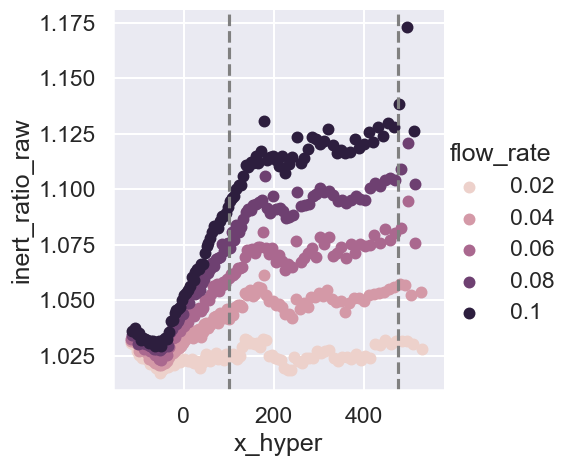

In [6]:
sns.lmplot(data=df_beads,
           x='x_hyper', y='inert_ratio_raw', hue='flow_rate',  palette='ch:',
           x_bins=100, x_estimator=np.median, fit_reg=False,
           ci=None)
plt.axvline(100, ls='--', c='gray')
plt.axvline(475, ls='--', c='gray')

### Save all data to same file

In [5]:
data_folder = os.path.join(data_exports, "20230725_paa_beads")
files = os.listdir(data_folder)
files

['20230725_paa_beads_all.tsv',
 '20230817_paa_beads_all.tsv',
 '20231113_paa_beads_all.tsv',
 's4_17um.tsv',
 's4_18um.tsv',
 's8_15um.tsv']

In [7]:
df_20230725 = pd.DataFrame()
for ff in tqdm(files):
    if not ff.startswith("2023"):
        df = pd.read_csv(os.path.join(data_folder, ff)
                         , sep="\t")
        bead_type = ff.split(".")[0]
        df['sample'] = bead_type
        if bead_type == 's4_17um':
            df['emodulus'] = 379
            df['radius'] = 7.56
        if bead_type == 's4_18um':
            df['emodulus'] = 669
            df['radius'] = 8.45
        if bead_type == 's8_15um':
            df['emodulus'] = 832
            df['radius'] = 6.81

        df_20230725 = pd.concat([df_20230725, df],
                                ignore_index=True)

df_20230725['date'] = '20230725'
df_20230725['wc'] = 60
df_20230725['strain_inert'] = df_20230725['inert_ratio_raw'] - 1

  0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
def df_fit_values(df_in, x_feature='x_shift', time_label='time_shift', poly_degree=7, x_0=-60):
    df_temp = df_in.copy()
    df_out = pd.DataFrame()
    samples = df_in['sample'].unique()
    pbar = tqdm(samples, desc="Iterating over samples")
    for sample in pbar:
        df_sample = df_temp[df_temp['sample'] == sample].copy()
        flow_rates = df_sample['flow_rate'].unique()
        for fr in flow_rates:
            df = df_sample[df_sample['flow_rate'] == fr].copy()
            df['x_shift'] = df['x_hyper'] - x_0
            x = df[x_feature]
            velocity_poly = fit_velocity(df, x_feature=x_feature, degree=poly_degree)
            df['velocity_fit'] = velocity_poly(x)
            er = extension_rate_from_velocity_poly(x, velocity_poly)
            df['extension_rate_fit'] = er
            df = recalculate_time(df, velocity_poly,
                                  x_feature=x_feature,
                                  time_label=time_label)
            # repeat time calculation for x_hyper -> time_hyper
            velocity_poly = fit_velocity(df, x_feature='x_hyper', degree=poly_degree)
            df = recalculate_time(df, velocity_poly,
                                  x_feature='x_hyper',
                                  time_label='time_hyper')
            df_out = pd.concat([df_out, df])

    extension_rate = df_out['extension_rate_fit']
    pos_x = df_out['x_hyper']
    diameter = (df_out['size_x'] + df_out['size_y']) / 2
    flow_rate = df_out['flow_rate']

    df_out['stress_ir'] \
        = total_stress_hyper_wc60_lc500_net_strain_ir_20240226(extension_rate,
                                                               pos_x,
                                                               diameter,
                                                               flow_rate)
    df_out['shear_stress_ir'] \
        = shear_stress_hyper_wc60_lc500_net_strain_ir_20240226(pos_x,
                                                               diameter,
                                                               flow_rate)
    df_out['normal_stress_ir'] \
        = normal_stress_hyper_wc60_lc500_net_strain_ir_20240226(extension_rate)
    return df_out

In [13]:
df_20230725 = df_fit_values(df_20230725[df_20230725['x_hyper'] < 540].copy(),
                            x_feature='x_shift', time_label='time_shift',
                            poly_degree=12, x_0=-40)

Iterating over samples:   0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
df_20230725

Unnamed: 0  area_msd  area_ratio    area_um    aspect  bright_avg  \
0                0     343.0    1.027697  162.99600  1.000000   129.76738   
1                1     344.0    1.029070  163.68960  1.000000   129.62400   
2                2     338.5    1.028065  160.91520  1.000000   129.80487   
3                3     340.5    1.035242  162.99600  1.000000   130.16129   
4                4     343.5    1.034935  164.38321  1.045454   130.44118   
...            ...       ...         ...        ...       ...         ...   
985485       69123     292.5    1.049573  141.95680  1.210526   134.67080   
985486       69124     291.0    1.030928  138.72000  1.222222   134.61371   
985487       69125     291.5    1.041166  140.33841  1.157895   133.54830   
985488       69126     300.0    1.053333  146.11841  1.210526   134.41994   
985489       69127     304.0    1.042763  146.58081  1.210526   132.50746   

        bright_sd      circ    deform  ell_angle  ...     x_shift  \
0        5.188624  0.986871  0.013129   0.152219  ...  -76.173645   
1        4.986912  0.988692  0.011308   3.125052  ...  -70.553100   
2        3.532256  0.990053  0.009947   0.120432  ...  -64.678770   
3        3.604180  0.991792  0.008208   0.287970  ...  -59.028990   
4        3.249108  0.991048  0.008952   0.189569  ...  -53.202210   
...           ...       ...       ...        ...  ...         ...   
985485   3.299306  0.980693  0.019307   2.999508  ...  465.873050   
985486   3.374866  0.979755  0.020245   3.006165  ...  491.570000   
985487   4.267351  0.984392  0.015608   2.995303  ...  518.117550   
985488   4.479098  0.985103  0.014897   2.955752  ...  545.775600   
985489   3.260680  0.969965  0.030035   2.874380  ...  573.942750   

        velocity_fit  extension_rate_fit  time_shift  stress_ir  \
0           0.003953           16.114704   -0.018073   3.257873   
1           0.004030           11.745967   -0.016666   2.258505   
2           0.004089            8.405389   -0.015219   1.661943   
3           0.004130            6.162729   -0.013845   1.374392   
4           0.004161            4.661800   -0.012440   1.303894   
...              ...                 ...         ...        ...   
985485      0.086826          131.387522    0.010680  98.766799   
985486      0.090202          130.606675    0.010970  96.710978   
985487      0.093538          117.237071    0.011259  94.016185   
985488      0.096298           78.974623    0.011550  75.553873   
985489      0.098141           70.684518    0.011840  72.540060   

        shear_stress_ir  normal_stress_ir  stress_ell  shear_stress_ell  \
0              0.313363          2.944510    4.931692          0.523845   
1              0.436998          1.821507    3.486966          0.523845   
2              0.566216          1.095727    2.470227          0.523845   
3              0.690495          0.683898    1.841956          0.523845   
4              0.856301          0.447593    1.476278          0.547927   
...                 ...               ...         ...               ...   
985485        36.715120         62.051679   95.256785         36.692157   
985486        35.029811         61.681167   93.351818         35.158404   
985487        38.678895         55.337290   90.813683         38.976180   
985488        42.639328         32.914545   75.572320         43.128600   
985489        44.727723         27.812338   73.623116         45.397567   

        normal_stress_ell  
0                4.407847  
1                2.963121  
2                1.946382  
3                1.318111  
4                0.928352  
...                   ...  
985485          58.564628  
985486          58.193413  
985487          51.837503  
985488          32.443720  
985489          28.225549  

[985224 rows x 63 columns]

Save to tsv

In [15]:
filename = "20231120_paa_beads_all.tsv"
df_20230725.to_csv(os.path.join(data_exports, "20230725_paa_beads",
                                filename),
                   sep='\t')

### Get median data

Additional strain and strain correction functions

In [5]:
def get_df_strain_features(df_in):
    df_in['strain_inert'] = df_in['inert_ratio_raw'] - 1
    # net tensile strain based on inertia ratio assuming shape is an ellipse
    df_in['net_strain_inert'] = ((df_in['inert_ratio_raw'] - 1)
                                 / np.sqrt(df_in['inert_ratio_raw']))
    df_in['taylor_strain_ir'] = ((df_in['inert_ratio_raw'] - 1)
                                 / (df_in['inert_ratio_raw'] + 1))
    # ellipse features
    df_in['net_strain_ell'] = ((df_in['ell_major'] - df_in['ell_minor'])
                               / np.sqrt(df_in['ell_major'] * df_in['ell_minor']))
    df_in['taylor_strain_ell'] = ((df_in['ell_major'] - df_in['ell_minor'])
                                  / (df_in['ell_major'] + df_in['ell_minor']))
    df_in['aspect_ell'] = df_in['ell_major'] / df_in['ell_minor']
    return df_in

def net_strain_ir_correction(x):
    """
    Correction for the net tensile strain based on inertia ratio caused by
    image distortions over the ROI with initial offset of strain. x needs to be
    the centered x-position in reference to the ROI length (at ROI center x=0).

    Parameters
    ----------
    x: x-position centered in ROI.

    Returns
    -------
    Delta strain to correct the strain value:
    strain_true = strain_measured = strain_delta
    """
    a = 1.9586860448121192e-07
    b = 2.4361520406921436e-05
    c = 0.0024712513556425834
    return a * x**2 + b * x + c


#### Read in data for all measurements
Data was already computed and only median data needs to be loaded. That's why the first cells are commented out

In [6]:
savepath = os.path.join(data_exports, "20230725_paa_beads",
                        "20231120_paa_beads_all.tsv")

In [7]:
df_beads = pd.read_csv(savepath, sep='\t', index_col=0)

In [8]:
df_beads = get_df_strain_features(df_beads)

In [9]:
roi_size_x = 680
df_beads['pos_x_center'] = df_beads['pos_x'] - roi_size_x / 2

In [10]:
df_beads['net_strain_ir_delta'] = net_strain_ir_correction(df_beads['pos_x_center'])
df_beads['net_strain_inert_corr'] = df_beads['net_strain_inert'] - df_beads['net_strain_ir_delta']

##### Filter the data

In [11]:
filter_idx = (df_beads['area_ratio'] < 1.05) \
             & (df_beads['aspect'] <= 1.8)
df_beads = df_beads[filter_idx].copy()

##### Cut data into bins

In [16]:
time_feat = 'time_shift'
x_0 = -40
idx_hyper = (x_0 < df_beads['x_hyper']) \
            & (df_beads['x_hyper'] < 490)

df_hyper = df_beads[idx_hyper].dropna()

# need to iterate over the flow rates to create bins then concatenate to big dataframe again
df_median = pd.DataFrame()
for fr in df_hyper['flow_rate'].unique():
    df_fr = df_hyper[df_hyper['flow_rate'] == fr]

    bins = pd.cut(df_fr[time_feat], 100)
    df_grouped = df_fr.groupby(by=['sample', 'flow_rate', bins],
                               as_index=False
                               )
    df_median = pd.concat([df_median, df_grouped.median()])

df_median.reset_index(inplace=True, drop=True)
df_median = df_median[df_median['strain_inert'] > 0].copy()

In [17]:
df_median

sample  flow_rate  Unnamed: 0  area_msd  area_ratio    area_um  \
0     s4_17um       0.02     26396.0    335.25    1.037965  160.45280   
1     s4_17um       0.02     25758.0    333.50    1.039161  160.45280   
2     s4_17um       0.02     24846.0    333.75    1.038191  159.99040   
3     s4_17um       0.02     24738.0    333.50    1.037230  160.45280   
4     s4_17um       0.02     25070.0    334.00    1.038226  159.99040   
...       ...        ...         ...       ...         ...        ...   
1493  s8_15um       0.10     38067.5    273.50    1.035581  131.09041   
1494  s8_15um       0.10     35204.0    278.50    1.035211  132.70880   
1495  s8_15um       0.10     37990.0    270.00    1.035857  129.24080   
1496  s8_15um       0.10     35206.0    281.00    1.036232  134.55841   
1497  s8_15um       0.10     34170.0    283.00    1.037225  135.94560   

        aspect  bright_avg  bright_sd      circ  ...  taylor_strain_ir  \
0     1.000000  130.335495   3.873556  0.989648  ...          0.015285   
1     1.045454  130.280990   3.217551  0.989539  ...          0.015074   
2     1.045454  130.179455   3.102919  0.989581  ...          0.016226   
3     1.045454  129.995855   3.045663  0.989618  ...          0.017812   
4     1.045454  129.840420   3.048808  0.989756  ...          0.017007   
...        ...         ...        ...       ...  ...               ...   
1493  1.111111  133.716210   3.495497  0.986083  ...          0.055973   
1494  1.111111  133.496350   3.406815  0.985936  ...          0.058662   
1495  1.111111  133.022800   3.565551  0.985386  ...          0.056445   
1496  1.111111  132.778150   3.713919  0.985645  ...          0.061021   
1497  1.157895  132.566150   3.640040  0.984664  ...          0.062712   

      taylor_strain_ell  aspect_ell  pos_x_center  net_strain_ir_delta  \
0              0.015514    1.031518    248.730805             0.020649   
1              0.017215    1.035033    246.099060             0.020329   
2              0.017400    1.035417    243.889180             0.020063   
3              0.018556    1.037814    241.377130             0.019763   
4              0.017810    1.036266    238.665040             0.019442   
...                 ...         ...           ...                  ...   
1493           0.058331    1.123889   -235.445080             0.007593   
1494           0.061172    1.130317   -243.300255             0.008139   
1495           0.059482    1.126489   -256.678320             0.009123   
1496           0.064139    1.137069   -265.971504             0.009848   
1497           0.067215    1.144117   -273.125984             0.010429   

      net_strain_inert_corr   diameter  stress_net_ir  shear_stress_net_ir  \
0                  0.009894  14.072846       3.178810             0.608790   
1                  0.009896  14.041861       3.374953             0.606112   
2                  0.012347  14.049763       3.547926             0.606795   
3                  0.015914  14.049652       3.743345             0.606785   
4                  0.014644  14.044025       3.955966             0.606299   
...                     ...        ...            ...                  ...   
1493               0.104423  12.721761      88.545637            27.555899   
1494               0.109191  12.830787      88.747290            28.363821   
1495               0.103811  12.632171      86.243490            28.224625   
1496               0.112758  12.889052      83.948663            29.840722   
1497               0.115119  12.943667      80.347470            30.492678   

      normal_stress_net_ir  
0                 2.573530  
1                 2.770574  
2                 2.940093  
3                 3.136809  
4                 3.353426  
...                    ...  
1493             60.986698  
1494             60.413348  
1495             57.757091  
1496             54.152601  
1497             50.220749  

[1481 rows x 74 columns]

Export median data

In [18]:
save_med_path = os.path.join(data_exports, "20240226_beads_median_data.tsv")
df_median.to_csv(save_med_path, sep='\t')